In [1]:
#Imports to avoid errors from numpy and pandas
import warnings
warnings.filterwarnings('ignore')

#Imports for visualization and data processing
import gym
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Imports for NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

In [2]:
#Lets create our environment!
env = gym.make('LunarLander-v2')

In [3]:
#Set our device for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Class for our Q and target network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_space):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space)
        
    def forward(self, state):
        forward_pass = self.fc1(state)
        forward_pass = F.relu(forward_pass)
        forward_pass = self.fc2(forward_pass)
        forward_pass = F.relu(forward_pass)
        return self.fc3(forward_pass)

In [5]:
#Class to create replay buffers of fixed size (buffer_size)
class ReplayBuffer:
    def __init__(self, action_space, buffer_size, minibatch_length):
        self.action_space = action_space
        self.memory = deque(maxlen=buffer_size)  
        self.minibatch_length = minibatch_length
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "terminal"])
    
    def __len__(self):
        return len(self.memory)

    def sample(self):
    #creates minibath of the specified length

        minibatch = random.sample(self.memory, k=self.minibatch_length)

        states = torch.from_numpy(np.vstack([e.state for e in minibatch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in minibatch if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in minibatch if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in minibatch if e is not None])).float().to(device)
        terminals = torch.from_numpy(np.vstack([e.terminal for e in minibatch if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, terminals)
    
    def append_experience(self, state, action, reward, next_state, terminal):
        #append experienced state action reward next-state tuple to buffer
        e = self.experience(state, action, reward, next_state, terminal)
        self.memory.append(e)

In [6]:
#This function creates a random agent which runs for n_episodes with max_t timestepsilon per episode iof no terminal state is reached
def random_agent(n_episodes=2000, max_t=1000):
    action_space = 4
    
    scores = []                       
    running_avg_scores = deque(maxlen=100)  
    for episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = random.choice(np.arange(action_space))
            next_state, reward, terminal, _ = env.step(action)
            
            state = next_state
            score += reward

            if terminal:
                break 
        running_avg_scores.append(score)       
        scores.append(score)              
      
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)))
        if np.mean(running_avg_scores)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(running_avg_scores)))
            break
    return scores

In [7]:
#Class for our "smart" agent used for DQN
class Agent():

    def __init__(self,loss_formula, buffer_size, minibatch_length, gamma, LR):
        self.state_size = 8
        self.action_space = 4  
        self.loss = loss_formula
        self.buffer_size = buffer_size
        self.minibatch_length = minibatch_length
        self.gamma = gamma
        self.LR = LR

        # Replay memory
        self.memory = ReplayBuffer(self.action_space, self.buffer_size, self.minibatch_length)
        self.t_step = 0

        # Q-Network
        self.q_network = QNetwork(self.state_size, self.action_space).to(device)
        self.qnetwork_target = QNetwork(self.state_size, self.action_space).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.LR)
    

    def step(self, state, action, reward, next_state, terminal):
        #append experience to memory and update counter to update after every 4 calls of this function

        # Save experience in replay memory
        self.memory.append_experience(state, action, reward, next_state, terminal)
        
        # Learn every 4 time steps.
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.minibatch_length:
                minibatch = self.memory.sample()
                self.learn(minibatch, self.gamma)

    def act(self, state, epsilon):
        #This function will select an action based on the current state
        #Similar to most act functions we have used in the past
        #it will use random to get a random number in a distribution between 0 and 1
        #if that random numnber is less than epsilon it will select a random action from action space
        #if the number is greater then it will chose optimal action
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()

        # epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_space))

    def learn(self, minibatch, gamma):

        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, terminals = minibatch

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        #Calculate  value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - terminals)
        #Calculate expected value from local network
        q_expected = self.q_network(states).gather(1, actions)
        
        ### Loss calculation, default value is huber, can change to mse for comparison in performance
        if self.loss == 'MSE':
            loss = F.mse_loss(q_expected, q_targets)
        else:
            loss = F.huber_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #update target network
        self.soft_update(self.q_network, self.qnetwork_target)                     


    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(0.001*local_param.data + (1.0-0.001)*target_param.data)

In [8]:
def dqn_fixed_epsilon(dqn_agent,n_episodes=3000, max_t=1000, epsilon = 0.15):

    scores = []                       
    running_avg_scores = deque(maxlen=100)                 
    print("fixed epsilon", epsilon)
    for episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = dqn_agent.act(state, epsilon)
            next_state, reward, terminal, _ = env.step(action)
            dqn_agent.step(state, action, reward, next_state, terminal)
            state = next_state
            score += reward
            if terminal:
                break 
        running_avg_scores.append(score)       
        scores.append(score)              

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)))
        if np.mean(running_avg_scores)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(running_avg_scores)))
            break
    return scores

In [9]:
def dqn(dqn_agent,n_episodes=2000, max_t=1000, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    #This function will take an agent with its parameyters as an argument and will handle the running of episodes
    #and interaction between agent and environment

    #parameters have default values for number of episodes, max timesteps, starting finishing and rate of decsay for epsilon
    #if epsilon_start = epsilon_end and epsilon_deay = 1 the epsilon will be fixed

    scores = []                       
    per_100_scores = {}
    running_avg_scores = deque(maxlen=100)  
    epsilon = epsilon_start                    
    for episode in range(n_episodes):
        state = env.reset()
        score = 0
        for _ in range(max_t):
            action = dqn_agent.act(state, epsilon)
            next_state, reward, terminal, _ = env.step(action)
            dqn_agent.step(state, action, reward, next_state, terminal)
            state = next_state
            score += reward

            if terminal:
                break 

        running_avg_scores.append(score)      
        scores.append(score)              
        epsilon = max(epsilon_end, epsilon_decay*epsilon) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(running_avg_scores)))
            per_100_scores[episode] = np.mean(running_avg_scores)
       
    return [scores, per_100_scores]

In [10]:
def get_moving_avg(data,window_size = 50):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]


        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    return moving_averages

In [11]:
def create_df(parameter, data):
    rows = []
    for param, results in df_data.items() :
        for episode, reward in results.items():
            new_row = {parameter: param,"episode":episode , "reward":reward}
            rows.append(new_row)
            
    return pd.DataFrame(rows)

# Parameter testing

## Test for Buffer Sizes

In [ ]:
#test for buffer sizes
buffer_sizes = [50000, 100000, 1000000]
buffer_results = { i : None for i in buffer_sizes }
buffer_data = { i : None for i in buffer_sizes }

for size in buffer_sizes:
    print("Testing buffer size: ", size)
    agent_huber = Agent(loss_formula = "Huber",buffer_size = size, minibatch_length = 64, gamma = 0.999, LR = 0.001)
    scores = dqn(dqn_agent = agent_huber)
    df_data[size] = scores[1]
    buffer_results[size] = scores[0]

Testing buffer size:  50000
Episode 0	Average Score: -204.31
Episode 100	Average Score: -113.32
Episode 200	Average Score: -54.790
Episode 201	Average Score: -53.08

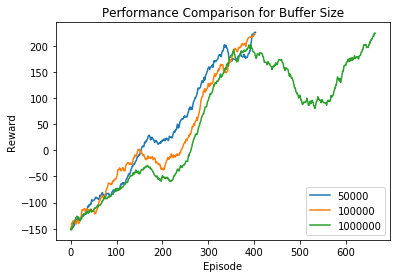

In [72]:
#Lets plot the results:
fig = plt.figure()

plt.title('Performance Comparison for Buffer Size')

for key, value in buffer_results.items():
    plt.plot(np.arange(len(get_moving_avg(value))), get_moving_avg(value), label = key)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

In [75]:
#Lets get dataframe of results for appendix
buffer_size_df = create_df("Buffer Size", df_data)
buffer_size_df

,Buffer Size,episode,reward
0,50000,100,-123.151691
1,50000,200,-41.313235
2,50000,300,41.542248
3,50000,400,164.050174
4,50000,453,200.745163
5,100000,100,-132.367429
6,100000,200,-25.029177
7,100000,300,-10.407015
8,100000,400,149.123312
9,100000,452,202.468272


## Test For Batch Sizes

In [64]:
#test for batch sizes
batch_sizes = [32, 64, 128]
batch_results = { i : None for i in batch_sizes }
batch_data = { i : None for i in batch_sizes }

for size in batch_sizes:
    print("Testing batch size: ", size)
    agent = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = size, gamma = 0.999, LR = 0.001)
    scores = dqn(dqn_agent = agent)
    batch_results[size] = scores[0]
    batch_data[size] = scores[1]

Testing batch size:  32
Episode 100	Average Score: -133.98
Episode 200	Average Score: -41.317
Episode 300	Average Score: 32.735
Episode 400	Average Score: 102.66
Episode 500	Average Score: 178.48
Episode 550	Average Score: 201.07
Environment solved in 450 episodes!	Average Score: 201.07
Testing batch size:  64
Episode 100	Average Score: -136.98
Episode 200	Average Score: -51.085
Episode 300	Average Score: 21.194
Episode 400	Average Score: 152.53
Episode 443	Average Score: 200.48
Environment solved in 343 episodes!	Average Score: 200.48
Testing batch size:  128
Episode 100	Average Score: -137.58
Episode 200	Average Score: -62.134
Episode 300	Average Score: 38.677
Episode 400	Average Score: 142.04
Episode 500	Average Score: 132.98
Episode 595	Average Score: 200.24
Environment solved in 495 episodes!	Average Score: 200.24


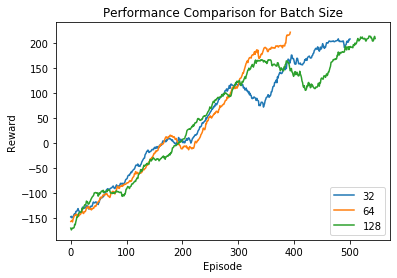

In [65]:
#Lets plot the results:
fig = plt.figure()

plt.title('Performance Comparison for Batch Size')

for key, value in batch_results.items():
    plt.plot(np.arange(len(get_moving_avg(value))), get_moving_avg(value), label = key)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

In [67]:
#Lets get dataframe of results for appendix
Batch_size_df = create_df("Batch Size", batch_data)
Batch_size_df

/Users/juanmarin/anaconda3/lib/python3.7/site-packages/pandas/core/internals/construction.py:588: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/juanmarin/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


,Batch Size,episode,reward
0,50000,100,-123.151691
1,50000,200,-41.313235
2,50000,300,41.542248
3,50000,400,164.050174
4,50000,453,200.745163
5,100000,100,-132.367429
6,100000,200,-25.029177
7,100000,300,-10.407015
8,100000,400,149.123312
9,100000,452,202.468272


## Test for Discount rate (gamma)

In [76]:
#test for gamma values
gamma_values = [0.9, 0.95, 0.99, 0.999]
gamma_results = { i : None for i in gamma_values }
gamma_data = { i : None for i in gamma_values }

for gamma_val in gamma_values:
    print("Testing gamma value: ", gamma_val)
    agent = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = gamma_val, LR = 0.001)
    scores_gamma = dqn(dqn_agent = agent)
    gamma_results[gamma_val] = scores_gamma[0]
    gamma_data[gamma_val] = scores_gamma[1]

Testing gamma value:  0.9
Episode 100	Average Score: -122.43
Episode 200	Average Score: -62.147
Episode 300	Average Score: -52.80
Episode 400	Average Score: -66.71
Episode 500	Average Score: -71.90
Episode 600	Average Score: -104.96
Episode 700	Average Score: -94.267
Episode 800	Average Score: -110.29
Episode 900	Average Score: -107.32
Episode 1000	Average Score: -106.25
Episode 1100	Average Score: -112.62
Episode 1200	Average Score: -117.24
Episode 1300	Average Score: -125.39
Episode 1400	Average Score: -130.17
Episode 1500	Average Score: -123.40
Episode 1600	Average Score: -117.90
Episode 1700	Average Score: -121.23
Episode 1800	Average Score: -122.18
Episode 1900	Average Score: -130.56
Episode 2000	Average Score: -120.19
Testing gamma value:  0.95
Episode 100	Average Score: -131.79
Episode 200	Average Score: -49.263
Episode 300	Average Score: -45.39
Episode 400	Average Score: -55.33
Episode 500	Average Score: -49.62
Episode 600	Average Score: -34.14
Episode 700	Average Score: -49.72

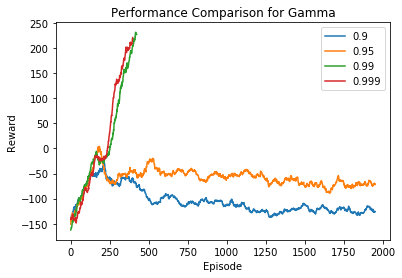

In [78]:
#Lets plot the results:
fig = plt.figure()

plt.title('Performance Comparison for Gamma')

for key, value in gamma_results.items():
    plt.plot(np.arange(len(get_moving_avg(value))), get_moving_avg(value), label = key)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "upper right")
plt.show()

In [ ]:
#Lets get dataframe of results for appendix
gamma_df = create_df("Gamma value", gamma_data)

## Test fixed value of epsilon

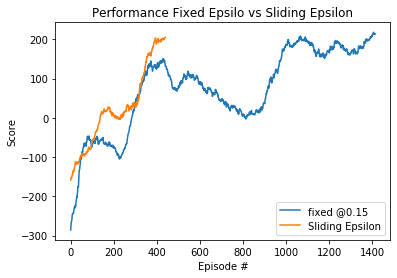

In [87]:
#Lets plot the results:
fig = plt.figure()

plt.title('Performance Fixed Epsilon vs Sliding Epsilon')

plt.plot(np.arange(len(get_moving_avg(scores_eps))), get_moving_avg(scores_eps), label = "fixed @0.15")
plt.plot(np.arange(len(get_moving_avg(buffer_results[100000]))), get_moving_avg(buffer_results[100000]), label = "Sliding Epsilon")


plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

## Epsilon decay rate

In [103]:
#test for epsilon decay rates
decay_rates = [0.9, 0.99, 0.995, 0.999]
epsilo_decay__results = { i : None for i in decay_rates }

for rate in decay_rates:
    print("Testing  decay rate: ", rate)
    agent = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
    scores = dqn(dqn_agent = agent, eps_decay=rate)
    epsilo_decay__results[rate] = scores


Testing  decay rate:  0.9
Episode 100	Average Score: -129.42
Episode 200	Average Score: -105.28
Episode 300	Average Score: -72.307
Episode 400	Average Score: 9.5756
Episode 500	Average Score: 8.358
Episode 600	Average Score: -1.35
Episode 700	Average Score: 30.06
Episode 800	Average Score: 70.59
Episode 900	Average Score: 30.35
Episode 1000	Average Score: 184.05
Episode 1023	Average Score: 200.88
Environment solved in 923 episodes!	Average Score: 200.88
Testing  decay rate:  0.99
Episode 100	Average Score: -104.36
Episode 200	Average Score: -54.840
Episode 300	Average Score: 17.640
Episode 400	Average Score: 138.45
Episode 500	Average Score: 191.24
Episode 600	Average Score: 192.20
Episode 624	Average Score: 201.21
Environment solved in 524 episodes!	Average Score: 201.21
Testing  decay rate:  0.995
Episode 100	Average Score: -129.37
Episode 200	Average Score: -59.416
Episode 300	Average Score: -25.48
Episode 400	Average Score: 144.46
Episode 500	Average Score: 185.69
Episode 544	Avera

In [ ]:
epsilo_decay__results

NameError: name 'epsilon_decay_results' is not defined

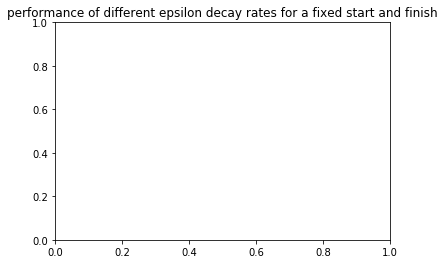

In [77]:
#Lets plot the results:
fig = plt.figure()

plt.title('performance of different epsilon decay rates for a fixed start and finish')

for key, value in epsilon_decay_results.items():
    plt.plot(np.arange(len(get_moving_avg(value))), get_moving_avg(value), label = key)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "upper right")
plt.show()

In [ ]:
#Lets get dataframe of results for appendix
decay_rate_df = create_df("Decay value", epsilon_decay_data)

 ## Test for learning rates

In [64]:
#test for learning rates
learning_rates = [0.01, 0.005, 0.001, 0.0001]
lr_results = { i : None for i in learning_rates}
lr_data = { i : None for i in learning_rates}

for lr in learning_rates:
    print("Testing  LR: ", lr)
    agent = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = lr)
    scores = dqn(dqn_agent = agent)
    lr_results[lr] = scores[0]
    lr_data[lr] = scores[1]

Testing  LR:  0.01
Episode 100	Average Score: -135.03
Episode 200	Average Score: -64.810
Episode 300	Average Score: -32.53
Episode 400	Average Score: 64.490
Episode 500	Average Score: 84.83
Episode 600	Average Score: 127.52
Episode 700	Average Score: 158.55
Episode 800	Average Score: 135.13
Episode 900	Average Score: 157.88
Episode 1000	Average Score: 189.08
Episode 1100	Average Score: 177.71
Episode 1169	Average Score: 200.86
Environment solved in 1069 episodes!	Average Score: 200.86
Testing  LR:  0.005
Episode 100	Average Score: -150.85
Episode 200	Average Score: -54.649
Episode 300	Average Score: -29.70
Episode 400	Average Score: 61.056
Episode 500	Average Score: 163.16
Episode 600	Average Score: 171.79
Episode 700	Average Score: 155.50
Episode 800	Average Score: 152.16
Episode 868	Average Score: 201.72
Environment solved in 768 episodes!	Average Score: 201.72
Testing  LR:  0.001
Episode 100	Average Score: -133.22
Episode 200	Average Score: -47.259
Episode 300	Average Score: 0.7440


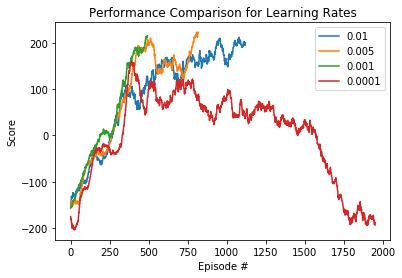

In [88]:
#Lets plot the results:
fig = plt.figure()

plt.title('Performance Comparison for Learning Rates')

for key, value in lr_results.items():
    plt.plot(np.arange(len(get_moving_avg(value))), get_moving_avg(value), label = key)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "upper right")
plt.show()

In [ ]:
#Lets get dataframe of results for appendix
learning_rate_df = create_df("LR Value", lr_data)

## Random agent implementation

In [18]:
random_agent_scores = random_agent()

Episode 100	Average Score: -187.20
Episode 200	Average Score: -161.75
Episode 300	Average Score: -182.92
Episode 400	Average Score: -189.28
Episode 500	Average Score: -168.14
Episode 600	Average Score: -183.99
Episode 700	Average Score: -179.38
Episode 800	Average Score: -191.51
Episode 900	Average Score: -197.68
Episode 1000	Average Score: -192.64
Episode 1100	Average Score: -171.50
Episode 1200	Average Score: -182.59
Episode 1300	Average Score: -172.43
Episode 1400	Average Score: -180.36
Episode 1500	Average Score: -183.73
Episode 1600	Average Score: -183.20
Episode 1700	Average Score: -198.46
Episode 1800	Average Score: -186.83
Episode 1900	Average Score: -188.30
Episode 2000	Average Score: -180.30


In [ ]:
#Plot best agent rewards
fig = plt.figure()

plt.axhline(200)

plt.plot(np.arange(len(get_moving_avg(Best_scores))), get_moving_avg(Best_scores), label = "Best Perofmring Agent")
plt.plot(np.arange(len(get_moving_avg(random_agent_scores))), get_moving_avg(random_agent_scores), label = "Random Moving average")

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "upper right")
plt.show()

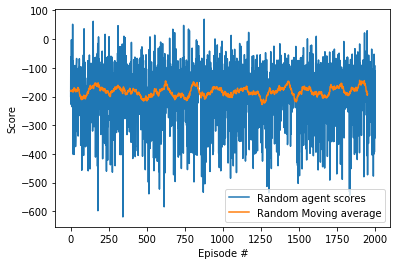

In [90]:
#Plot random agent rewards
fig = plt.figure()

plt.plot(np.arange(len(random_agent_scores)), random_agent_scores, label = "Random agent scores")
plt.plot(np.arange(len(get_moving_avg(random_agent_scores))), get_moving_avg(random_agent_scores), label = "Random Moving average")

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

## MSE vs Huber Loss function

In [33]:
print("MSE scores")
new_agent_mse = Agent(loss_formula = "MSE",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
MSE_scores = dqn(dqn_agent = new_agent_mse)[0]

MSE scores
Episode 100	Average Score: -168.08
Episode 200	Average Score: -118.49
Episode 300	Average Score: -21.735
Episode 328	Average Score: -11.31

KeyboardInterrupt: 

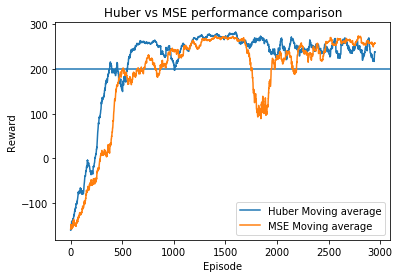

In [30]:
#Plot agent rewards for different error functions
fig = plt.figure()

plt.title('Huber vs MSE performance comparison')

plt.axhline(200)

plt.plot(np.arange(len(get_moving_avg(Best_scores))), get_moving_avg(Best_scores), label = "Huber Moving average")
plt.plot(np.arange(len(get_moving_avg(MSE_scores))), get_moving_avg(MSE_scores), label = "MSE Moving average")

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

In [85]:
def dqn_no_limit(dqn_agent,n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        
    per_100_scores = {}
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = dqn_agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            #if i_episode>700:
                #env.render()
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            per_100_scores[i_episode] = np.mean(scores_window)
    return [scores, per_100_scores]


In [87]:
print("Huber scores 1000 episodes")
new_agent_huber = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
Huber_scores_full = dqn_no_limit(dqn_agent = new_agent_huber)[0]

print("MSE scores 1000 episodes")
agent_mse_1000 = Agent(loss_formula = "MSE",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
MSE_scores_full = dqn_no_limit(dqn_agent = agent_mse_1000)[0]

Huber scores 1000 episodes
Episode 100	Average Score: -143.19
Episode 200	Average Score: -30.746
Episode 300	Average Score: -3.678
Episode 400	Average Score: 111.28
Episode 500	Average Score: 191.05
Episode 600	Average Score: 210.77
Episode 700	Average Score: 232.11
Episode 800	Average Score: 239.98
Episode 900	Average Score: 242.15
Episode 1000	Average Score: 245.11
MSE scores 1000 episodes
Episode 100	Average Score: -115.92
Episode 200	Average Score: -47.937
Episode 300	Average Score: 47.922
Episode 400	Average Score: 186.21
Episode 500	Average Score: 243.57
Episode 600	Average Score: 253.17
Episode 700	Average Score: 263.29
Episode 800	Average Score: 264.83
Episode 900	Average Score: 263.85
Episode 1000	Average Score: 257.39


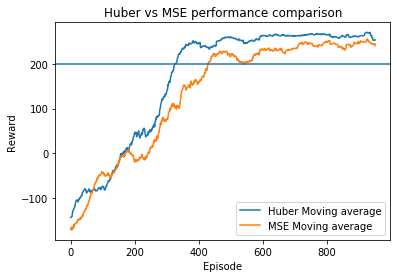

In [90]:
#Plot agent rewards for different error functions
fig = plt.figure()

plt.title('Huber vs MSE performance comparison')

plt.plot(np.arange(len(get_moving_avg(MSE_scores_full))), get_moving_avg(MSE_scores_full), label = "Huber Moving average")
plt.plot(np.arange(len(get_moving_avg(Huber_scores_full))), get_moving_avg(Huber_scores_full), label = "MSE Moving average")
plt.axhline(200)


plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

## Comparing performance of our best agent with baseline

In [98]:
print("Running best agent for 1000 episodes:")
best_agent = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
dqn_performance = dqn_no_limit(dqn_agent = best_agent)
best_scores = dqn_performance[0]
best_scores_df = dqn_performance[1]

print("Running random agent for comparison:")
random_agent_final = random_agent()


Running best agent for 1000 episodes:
Episode 100	Average Score: -105.49
Episode 200	Average Score: -31.173
Episode 300	Average Score: 23.098
Episode 400	Average Score: 88.58
Episode 500	Average Score: 155.37
Episode 600	Average Score: 199.38
Episode 700	Average Score: 213.02
Episode 800	Average Score: 219.46
Episode 900	Average Score: 256.65
Episode 1000	Average Score: 249.78
Running random agent for comparison:
Episode 100	Average Score: -172.54
Episode 200	Average Score: -171.11
Episode 300	Average Score: -174.24
Episode 400	Average Score: -164.11
Episode 500	Average Score: -180.96
Episode 600	Average Score: -182.21
Episode 700	Average Score: -195.06
Episode 800	Average Score: -169.55
Episode 900	Average Score: -173.87
Episode 1000	Average Score: -186.86


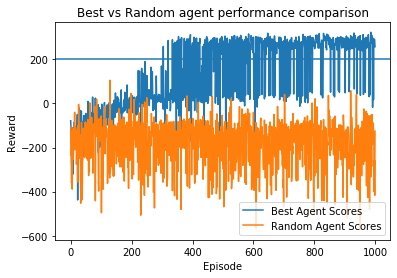

In [99]:
#Plot best agent vs random agent rewards 
fig = plt.figure()

plt.title('Best vs Random agent performance comparison')

plt.plot(np.arange(len(best_scores)), best_scores, label = "Best Agent Scores")
plt.plot(np.arange(len(random_agent_final)), random_agent_final, label = "Random Agent Scores")

plt.axhline(200)


plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "lower right")
plt.show()

NameError: name 'get_moving_avg' is not defined

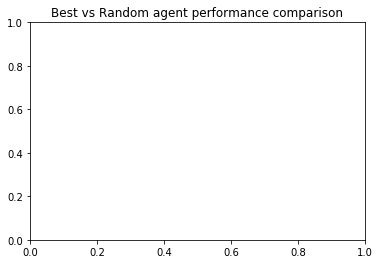

In [2]:
#Plot best agent vs random agent average rewards 
fig = plt.figure()

plt.title('Best vs Random agent performance comparison')

plt.plot(np.arange(len(get_moving_avg(best_scores))), get_moving_avg(best_scores), label = "Best Agent Average")
plt.plot(np.arange(len(get_moving_avg(random_agent_final))), get_moving_avg(random_agent_final), label = "Random Agent Average")
plt.axhline(200)


plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(loc = "right")
plt.show()

## Lets get videos of our best agent!

In [13]:
def dqn_render(dqn_agent,n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        
    per_100_scores = {}
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        
        
        if i_episode%100==0:
            print("Will now render")
            time.sleep(2)
        
        
        for t in range(max_t):
            
            if i_episode%100==0 or i_episode%100==98 or i_episode%100==99 or i_episode==1 or i_episode==2:
                

                action = dqn_agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)

                env.render()
                
                dqn_agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            
            
            else:
                action = dqn_agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                dqn_agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            
            
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            per_100_scores[i_episode] = np.mean(scores_window)
    return [scores, per_100_scores]

In [14]:
print("Running best agent for 1000 episodes:")
best_agent_video = Agent(loss_formula = "Huber",buffer_size = 100000, minibatch_length = 64, gamma = 0.999, LR = 0.001)
dqn_performance_video = dqn_render(dqn_agent = best_agent_video)
best_scores = dqn_performance_video[0]
best_scores_df = dqn_performance_video[1]

Running best agent for 1000 episodes:
Episode 99	Average Score: -131.89Will now render
Episode 100	Average Score: -133.32
Episode 199	Average Score: -55.77Will now render
Episode 200	Average Score: -53.19
Episode 299	Average Score: 26.62Will now render
Episode 300	Average Score: 27.00
Episode 399	Average Score: 167.27Will now render
Episode 400	Average Score: 169.67
Episode 499	Average Score: 222.79Will now render
Episode 500	Average Score: 222.69
Episode 599	Average Score: 224.92Will now render
Episode 600	Average Score: 225.19
Episode 699	Average Score: 245.88Will now render
Episode 700	Average Score: 245.85
Episode 799	Average Score: 265.62Will now render
Episode 800	Average Score: 265.57
Episode 899	Average Score: 265.65Will now render
Episode 900	Average Score: 265.48
Episode 999	Average Score: 268.51Will now render
Episode 1000	Average Score: 268.88


NameError: name 'dqn_performance' is not defined